In [1]:
import pybullet as p
import pybullet_data
import pathlib
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
from Gantry.envs.GantrySimulation import GantrySimulation
from Gantry.controller.SNS_layer import SNS_layer, SENSORY_LAYER_1_INPUT_SIZE, SENSORY_LAYER_1_SIZE, SENSORY_LAYER_2_INPUT_SIZE, SENSORY_LAYER_2_SIZE, THETA_MAX, THETA_MIN, F_MAX, F_MIN, sensory_layer_1, sensory_layer_2, R, perceptor, controller

alloc!
alloc!
alloc!
alloc!
alloc!
alloc!
alloc!
alloc!
alloc!
alloc!
alloc!
alloc!


In [5]:
def pick_and_place():
    gS = GantrySimulation() #gantryURDFfile = "URDF//GrasperAndGantry//urdf//GrasperAndGantry.urdf"
    # add object to the simulation at the center of the plate
    gS.addObjectsToSim("PickupCube", startPos=[0, 0, (0.063+0.02)], mass_kg=1, sizeScaling=0.6,
                       sourceFile=str(pathlib.Path.cwd()/"Gantry\\envs\\URDF\\PickUpObject_URDF\\urdf\\PickUpObject_URDF.urdf"))
    #SoftSupportInit = p.loadURDF("URDF/SoftGrasperAssembly_SimplifiedTilt/urdf/SoftGrasperAssembly_SimplifiedTilt.urdf",
    #                              [0, 0, 0.52816* gS.lengthScale], globalScaling=gS.lengthScale, useFixedBase=False,
    #                              flags=p.URDF_USE_SELF_COLLISION_INCLUDE_PARENT | p.URDF_USE_MATERIAL_COLORS_FROM_MTL)
    #
    #
    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.setAdditionalSearchPath("C://Users//Ravesh//BulletPhysics//bullet3//examples//pybullet//gym//pybullet_data")

    positionset = []
    targetpositionset = []
    forceset = []
    neuronset = []

    GUI_control = True

    while (not gS.CheckStopSim()):  # check to see if the button was pressed to close the sim
        timeStart=time.perf_counter()

        GUIcontrolTarget = gS.bulletClient.readUserDebugParameter(
            gS.GUIcontrols["GUIcontrolId"])
        if GUIcontrolTarget % 2 == 0 and GUI_control is True:
            GUI_control = False
            gS.simCounter = 0
            object_position = torch.Tensor([0, 0, -0.316]).unsqueeze(dim=0)
            target_position = torch.Tensor(
                [0.15, 0.15, -0.335]).unsqueeze(dim=0)

        ts = gS.timeStep  # time step of the simulation in seconds
        nsteps = gS.simCounter  # of simulation steps taken so far
        timev = ts*nsteps
        x = gS.bulletClient.getJointState(
            gS.gantryId, gS.GantryLinkIndex_dict["GantryHeadIndex"])[0]
        y = gS.bulletClient.getJointState(
            gS.gantryId, gS.GantryLinkIndex_dict["BasePositionIndex"])[0]
        z = gS.bulletClient.getJointState(
            gS.gantryId, gS.GantryLinkIndex_dict["ZAxisBarIndex"])[0]
        # JawRadialPos = gS.bulletClient.getJointState(
        #     gS.gantryId, gS.gantryLinkDict["SJ1"])[0]
        force_feedback_1 = gS.bulletClient.getContactPoints(
            gS.gantryId, gS.objects["PickupCube"].objId, gS.gantryLinkDict["SJ1"], -1)
        force_feedback_2 = gS.bulletClient.getContactPoints(
            gS.gantryId, gS.objects["PickupCube"].objId, gS.gantryLinkDict["SJ2"], -1)
        force_feedback_3 = gS.bulletClient.getContactPoints(
            gS.gantryId, gS.objects["PickupCube"].objId, gS.gantryLinkDict["SJ3"], -1)
        if len(force_feedback_1) != 0:
            force_1 = np.linalg.norm(sum(np.array([np.array(x[7])*x[9] for x in force_feedback_1])),2)
        else:
            force_1 = 0
        if len(force_feedback_2) != 0:
            force_2 = np.linalg.norm(sum(np.array([np.array(x[7])*x[9] for x in force_feedback_2])),2)
        else:
            force_2 = 0
        if len(force_feedback_3) != 0:
            force_3 = np.linalg.norm(sum(np.array([np.array(x[7])*x[9] for x in force_feedback_3])),2)
        else:
            force_3 = 0
        gripper_position = torch.Tensor([x, y, z]).unsqueeze(dim=0)
        force = torch.Tensor([force_1, force_2, force_3]).unsqueeze(dim=0)
        print("force_1:",str(force_1))
        print("force_2:",str(force_2))
        print("force_3:",str(force_3))

        if GUI_control is False:
            commands = perceptor.forward(
                gripper_position, object_position, target_position, force)
            [move_to_pre_grasp, move_to_grasp, grasp, lift_after_grasp, move_to_pre_release,
                move_to_release, release, lift_after_release] = commands.squeeze(dim=0).numpy()
            [x_d, y_d, z_d, JawRadialPos] = controller.forward(
                object_position, target_position, commands).numpy()
            if lift_after_release > 10:
                object_position = torch.Tensor([0, 0, 0]).unsqueeze(dim=0)

            positionset.append([x,y,z])
            targetpositionset.append([x_d,y_d,z_d])
            forceset.append([force_1, force_2, force_3])
            neuronset.append([move_to_pre_grasp, move_to_grasp, grasp, lift_after_grasp, move_to_pre_release, move_to_release, release, lift_after_release])

        else:
            [x_d, y_d, z_d, JawRadialPos] = [0, 0, 0, 0]


        GrasperArguments = {"frictionCoefficient":0.75,"PressureValue":2.5, #change the pressure value to see change in effective stiffness.
                             "TargetJawPosition":JawRadialPos, "MaxJawForce":20, "MaxVel":0.1,
                             "MaxVertForce":100,
                             "TargetVertPosition":0, "MaxVertVel":0.1}

        ArgumentDict = {"x_gantryHead": x_d, "y_BasePos": y_d, "z_AxisBar": z_d, "x_force": 50, "y_force": 500,
                        "z_force": 500, "GrasperArguments": GrasperArguments}

        # ---------step the simulation----------
        gS.stepSim(usePositionControl=True, GUI_override=False, **ArgumentDict)  # pass argument dict to function

    
    return positionset, targetpositionset, forceset, neuronset

In [6]:
positionset, targetpositionset, forceset, neuronset = pick_and_place()

force_1: 0
force_2: 0
force_3: 0
GUI Control
force_1: 0
force_2: 0
force_3: 0
GUI Control
ObjectBaseJoint:[-9.18331761e-06  3.00034982e-05 -1.87357224e+01]
force_1: 0
force_2: 0
force_3: 0
GUI Control
ObjectBaseJoint:[ 5.59910015e-04 -8.58804865e-05 -9.19632620e+00]
force_1: 0
force_2: 0
force_3: 0
GUI Control
ObjectBaseJoint:[ 1.84428624e-04 -3.26606308e-05 -9.15192044e+00]
force_1: 0
force_2: 0
force_3: 0
GUI Control
ObjectBaseJoint:[ 1.92470771e-04 -4.00380562e-05 -9.20311590e+00]
force_1: 0
force_2: 0
force_3: 0
GUI Control
ObjectBaseJoint:[ 6.48369983e-04 -4.36007468e-04 -9.24165606e+00]
force_1: 0
force_2: 0
force_3: 0
GUI Control
ObjectBaseJoint:[ 6.48749502e-04 -4.37172033e-04 -9.29206244e+00]
force_1: 0
force_2: 0
force_3: 0
GUI Control
ObjectBaseJoint:[ 5.89789155e-04 -4.28839321e-04 -9.34289186e+00]
force_1: 0
force_2: 0
force_3: 0
GUI Control
ObjectBaseJoint:[ 5.99566135e-04 -4.51151307e-04 -9.37413473e+00]
force_1: 0
force_2: 0
force_3: 0
GUI Control
ObjectBaseJoint:[ 5.92

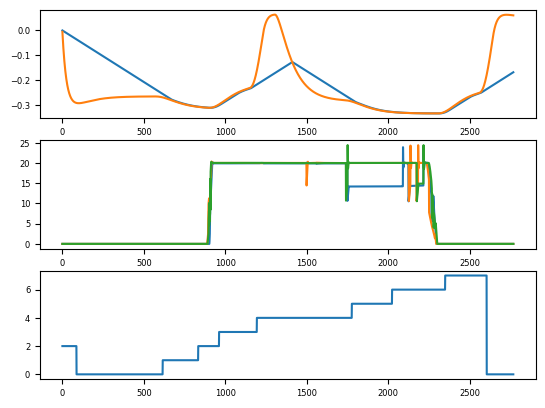

In [8]:
position_set = np.array(positionset)
target_position_set = np.array(targetpositionset)
force_set = np.array(forceset)
neuron_set = np.array(neuronset)
neuron_set[neuron_set<0] = 0

plt.figure()
plt.subplot(311)
plt.plot(position_set[:,-1])
plt.plot(target_position_set[:,-1])

plt.subplot(312)
plt.plot(force_set)

plt.subplot(313)
plt.plot(np.argmax(neuron_set,axis=1))
#plt.plot(neuron_set[:,6])
plt.show()

In [9]:
57.5*0.6

34.5

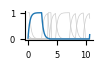

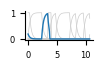

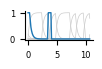

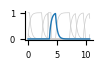

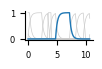

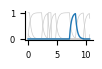

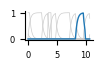

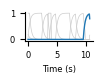

In [7]:
matplotlib.rcParams.update({'font.size': 6})
position_set = np.array(positionset)
target_position_set = np.array(targetpositionset)
force_set = np.array(forceset)
neuron_set = np.array(neuronset)
neuron_activity_set = np.minimum(np.maximum(neuron_set,np.zeros_like(neuron_set)),R * np.ones_like(neuron_set)) / R
time_len = 2570
for i in range(2):
    for j in range(4):
        fig, ax = plt.subplots(figsize=(7/4/2,3/4/2))
        for k in range(8):
            if k != i * 4 + j:
                ax.plot(np.arange(0,time_len)/240,neuron_activity_set[:time_len,k],color=(0.8, 0.8, 0.8),alpha=1,linewidth=0.5)
        ax.plot(np.arange(0,time_len)/240,neuron_activity_set[:time_len,i * 4 + j],linewidth=1)
        ax.set_yticks([0,1])
        ax.set_xticks([0,5,10])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if i * 4 + j == 7:
            ax.set_xlabel('Time (s)')
        #plt.savefig("myimg"+str(i * 4 + j)+".svg")